In [7]:
%matplotlib nbagg
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [1]:
import csv
from bicis.etl.unify_raw_data import UnifyRawData
input_fname = UnifyRawData().output().path.replace('.csv', '_sample.csv')

In [4]:
from pyspark.sql import SparkSession
import pyspark
import findspark

findspark.init()
pyspark.SparkContext.setSystemProperty('spark.executor.memory', '4g')
sc = pyspark.SparkContext(appName="test")
spark_sql = SparkSession.builder.appName("test").getOrCreate()

In [21]:
from pyspark.sql import Row

def _translate_doc(doc):
    res = doc.asDict()
    for date_field in 'rent_date return_date'.split():
        res[date_field + '_date'] = doc[date_field].date()
        res[date_field + '_hour'] = doc[date_field].hour
        res[date_field + '_weekday'] = doc[date_field].isoweekday()
    return Row(**res)

In [23]:
df = (
    spark_sql
    .read
    .load(input_fname, format="csv", sep=",", inferSchema="true", header="true")
    .rdd
    .map(_translate_doc)
    .toDF()
)



In [39]:
a = (
    df
    .groupBy('src_station', 'rent_date_weekday')
    .count()
    .withColumnRenamed('count', 'n_rents')
)
b = (
    df
    .groupBy('dst_station', 'return_date_weekday')
    .count()
    .withColumnRenamed('count', 'n_returns')
)

In [59]:
a.join?

In [48]:
c = a.join(b, (a.src_station == b.dst_station) & (a.rent_date_weekday == b.return_date_weekday))
d = c.withColumnRenamed('src_station', 'station').drop('dst_station').withColumnRenamed('rent_date_weekday', 'weekday').drop('return_date_weekday')

In [63]:
d.write.csv('a.csv')

In [49]:
pdf = d.toPandas()

<IPython.core.display.Javascript object>


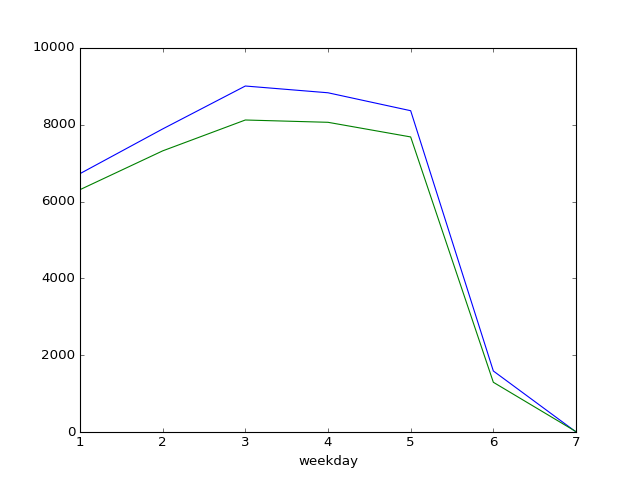

In [52]:
figure()
spdf = pdf[pdf.station == 'INDEPENDENCIA'].set_index('weekday').sort_index()
spdf.n_rents.plot()
spdf.n_returns.plot()

In [32]:
d[d.src_station == 'ADUANA'].set_index('return_date_weekday')

,src_station,rent_date_weekday,count,dst_station,count
return_date_weekday,,,,,
6,ADUANA,6,2079,ADUANA,2025
2,ADUANA,2,12986,ADUANA,11200
4,ADUANA,4,14049,ADUANA,11978
5,ADUANA,5,13466,ADUANA,11638
7,ADUANA,7,7,ADUANA,20
1,ADUANA,1,11568,ADUANA,9402
3,ADUANA,3,13711,ADUANA,11677


<IPython.core.display.Javascript object>


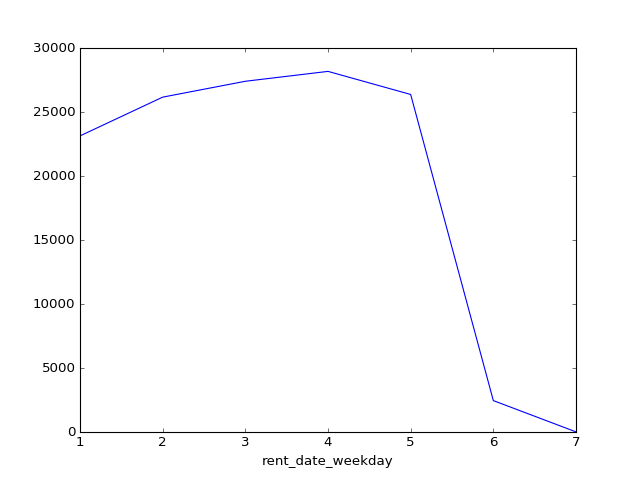

In [17]:
figure()
pandas_df[pandas_df.src_station == 'RETIRO'].set_index('rent_date_weekday').sort_index()['count'].plot()

In [9]:
figure()
pandas_df[pandas_df.src_station == u'JOSE MARMOL'].groupby('rent_date_weekday')['count'].sum().plot()

<IPython.core.display.Javascript object>

TypeError: Empty 'DataFrame': no numeric data to plot

In [8]:
def head(n):
    def f(index, iter):
        while index < n:
            try:
                yield iter.next()
                index += 1
            except StopIteration:
                break
    return f

In [ ]:
from StringIO import StringIO

l = group_by_day(
    sc.textFile(input_fname)
        .mapPartitionsWithIndex(skip_header)
        .map(parse_row_string)
        .mapPartitionsWithIndex(head(100000))
    #         .map(lambda x: (x['src_station'], x))
    #         .filter(lambda x: x['src_station'] == 'RETIRO')
    #         .groupByKey(4)
    #         .map(lambda x:x[1])
    #         .collect()
)


# df = spark_sql.createDataFrame(l)
pepe = l.collect()

In [ ]:
l

In [8]:
datetime.strftime

In [26]:
a = l[0][1]

In [30]:
%matplotlib nbagg
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'e', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<IPython.core.display.Javascript object>


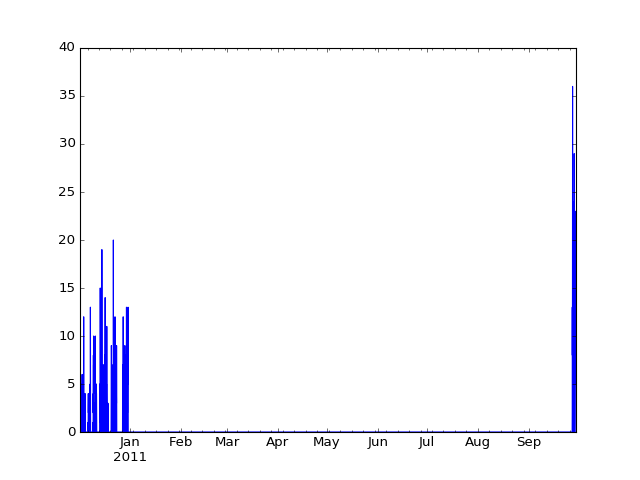

In [31]:
figure()
a.sort_index().resample('H').count().plot()